# Learn PPCA

In [1]:
import scipy.io as io
import matplotlib.pyplot as plt
import numpy as np

### Load the data from the Markdown

In [2]:
data = io.loadmat('tonnage.mat')

In [3]:
X = data['X']
y = data['y'][:,0]
np.moveaxis(X,0,1).shape

(4, 1201, 582)

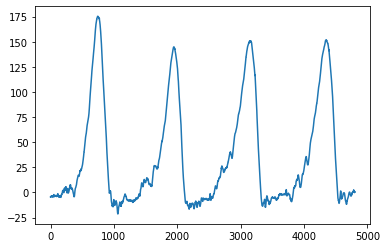

In [4]:
vx = np.moveaxis(X,0,1).reshape(-1,582).T
y[y==5]=2
plt.plot(vx[0,:])


In [9]:
from sklearn.decomposition import PCA
modelall = [[] for i in range(5)]
Wall = [[] for i in range(5)]
sigmaall = np.zeros(5)
ncomponents = [10,8,8,8,8]
for i in range(5):
    modelall[i] = PCA(svd_solver='auto', n_components=ncomponents[i])
    modelall[i].fit(vx[y==i])
    Wall[i] = modelall[i].components_.T
    sigmaall[i] = np.sqrt(modelall[i].noise_variance_)
    print(np.sum(modelall[i].explained_variance_ratio_))

0.817030803135414
0.8392424738525786
0.8273479631665371
0.8119588926791212
0.8351399586668791


In [10]:
def fast_logdet(A):
    """Compute log(det(A)) for A symmetric
    Equivalent to : np.log(nl.det(A)) but more robust.
    It returns -Inf if det(A) is non positive or is not defined.
    Parameters
    ----------
    A : array_like
        The matrix
    """
    sign, ld = np.linalg.slogdet(A)
    if not sign > 0:
        return -np.inf
    return ld


### Solution of PCA is given by
PCA solution is given by
$$X = U S V^T$$ where $V$ is the loading matrix (pca.component.T). 
The PPCA solution is givne by 
$$W = V(L-\sigma^2I)^{1/2}.$$
$L$ is diagonal matrix with eigen values of Sample covariance and $\sigma$ is the noise;

see book  [PRML](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf) (12.45)

In [11]:
WPPCAall = [[] for i in range(5)]
for i in range(5):
    exp_var = modelall[i].explained_variance_
    exp_var_diff = np.maximum(exp_var - modelall[i].noise_variance_, 0.)
    WPPCAall[i]=modelall[i].components_.T.dot(np.diag(np.sqrt(exp_var_diff)))

Use [matrix inverse lemma](https://en.wikipedia.org/wiki/Woodbury_matrix_identity) to compute the inverse of $$C^{-1} = (WW' + \sigma^2 I)^{-1} = \sigma^{-2} I -  \sigma^{-2} W ( W'W + \sigma^{2}I)^{-1} W'  $$
see book [PRML](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf) Eq. (12.40)

In [12]:
def get_precision(W,sigma):
    p = W.shape[0]
    n = W.shape[1]
    M = W.T@W + sigma**2*np.eye(n)
    precision = 1/sigma**2 * np.eye(p)- 1/sigma**2*W@np.linalg.solve(M,W.T)
    return precision

In [13]:
precision = [[] for i in range(5)]
for i in range(5):
    precision[i] = get_precision(WPPCAall[i],sigmaall[i])


see book [PRML](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf) Eq. (12.44)

In [14]:
def loglk(X,mean,precision):
    log_like = 0
    Xr = X - mean
    p = len(mean)
    log_like = -.5 * (Xr * (np.dot(Xr, precision))).sum(axis=1)
    log_like -= .5 * (p * np.log(2. * np.pi) -
                      fast_logdet(precision))

    return log_like

Select columns from $W$

In [16]:
def create_sensing_matrix(p,index):
    p_obs = len(index);
    Z = np.zeros((p,p_obs));
    for ii,i in enumerate(index):
        Z[i,ii] = 1
    return Z


In [17]:
# pa = len(index)
# r = np.zeros((582,4))
# isample = np.arange(20,)
# for isample in range(582):
#     print(isample)
#     y = vx[isample,:].reshape(-1,1)
#     lrt = np.zeros(5)
#     for i in range(5):
#         lrt[i] = np.mean(loglk(y,modelall[i].mean_,precision[i]))
#     LRT = np.cumsum(np.diff(lrt,1))
#     for i in range(4):
#         r[isample,i] = np.log1p(np.exp(r[isample-1,i]))+LRT[i]
    


### Created Selected Sampling in index matrix

In [18]:
xchoice0 = np.random.choice(np.where(y==0)[0], size=100, replace=True)
xchoice4 = np.random.choice(np.where(y==4)[0], size=100, replace=True)
sampleindex = np.concatenate((xchoice0,xchoice4))

In [28]:
index = [4000]
index
pa = len(index)
A = create_sensing_matrix(4804,index)
r = np.zeros((582,4))
LRT = np.zeros((582,4))
for ii,isample in enumerate(sampleindex):
    print(isample)
    xi = vx[isample,:]
    lrt = np.zeros(5)
    for i in range(5):
        Wa = (A.T@WPPCAall[i])
        precision = get_precision(Wa,sigmaall[i])
        mean = modelall[i].mean_[index]
        xa = (A.T@xi.T).reshape(1,pa)
        lrt[i] = np.mean(loglk(xa,mean,precision))
    LRT[ii] = np.cumsum(np.diff(lrt,1))
    for i in range(4):
        r[ii,i] = np.log1p(np.exp(r[ii-1,i]))+LRT[ii,i]
    


275
67
43
222
268
298
283
98
279
278
0
47
142
90
121
64
270
29
102
179
272
33
175
264
43
15
262
119
11
75
304
202
206
174
29
240
264
285
3
268
274
45
285
92
42
116
52
0
282
90
12
102
265
69
100
151
66
126
178
159
271
233
121
50
266
43
38
64
138
140
220
134
297
175
103
273
219
246
222
51
169
56
277
175
184
57
276
154
230
132
7
93
7
256
94
43
225
60
103
294
506
466
451
476
492
467
485
477
478
479
459
486
448
455
453
499
470
479
454
508
495
446
489
493
465
480
474
462
469
461
512
469
496
445
467
460
460
450
482
473
460
453
512
497
511
460
486
504
478
482
512
511
511
483
476
460
494
452
448
444
464
457
477
499
483
509
461
450
448
511
447
493
483
507
489
484
459
451
512
476
484
507
480
461
503
461
455
510
470
506
487
484
490
486
449
491
472
449
473
511


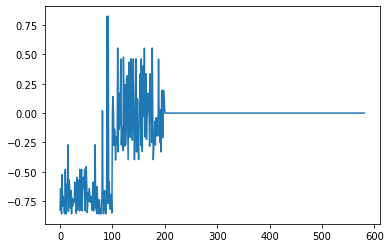

In [29]:
plt.plot(LRT[:,3])

In [180]:
r.shape

(582, 4)